In [23]:
import re
import torch
import numpy as np

def parse_graph_data(file_path):
    graphs = []
    current_graph = {}
    blank_line_count = 0
    parsing_edges = True
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            if not line:
                blank_line_count += 1
                if blank_line_count == 1:
                    parsing_edges = False
                elif blank_line_count == 3:
                    if current_graph:
                        graphs.append(current_graph)
                        current_graph = {}
                    blank_line_count = 0
                    parsing_edges = True
                continue
            
            blank_line_count = 0
            
            if parsing_edges:
                vertex, neighbors = line.split(':')
                if 'vertices' not in current_graph:
                    current_graph['vertices'] = []
                    current_graph['edges'] = []
                vertex = int(vertex)
                neighbors = list(map(int, neighbors.split()))
                current_graph['vertices'].append(vertex)
                for neighbor in neighbors:
                    if {vertex, neighbor} not in current_graph['edges']:
                        current_graph['edges'].append({vertex, neighbor})
            else:
                key, value = re.split(r':\s*', line, 1)
                try:
                    value = float(value)
                except ValueError:
                    pass
                current_graph[key] = value
    
    if current_graph:
        graphs.append(current_graph)
    
    return graphs

def create_adjacency_matrix(vertices, edges):
    n = max(vertices)
    matrix = np.zeros((n, n), dtype=np.int8)
    for edge in edges:
        i, j = list(edge)
        matrix[i-1][j-1] = 1
        matrix[j-1][i-1] = 1
    return matrix

def graph_to_tensor(graph):
    vertices = graph['vertices']
    edges = graph['edges']
    adj_matrix = create_adjacency_matrix(vertices, edges)
    
    # Select the invariants we want to use
    selected_invariants = [
        'Genus',
        'Laplacian Largest Eigenvalue',
        'Number of Zero Eigenvalues',
        'Second Largest Eigenvalue',
        'Smallest Eigenvalue',
        'Maximum Degree',
        'Minimum Degree',
        'Number of Edges',
        'Number of Vertices',
    ]
    
    invariants = [graph.get(inv, 0) for inv in selected_invariants]

    # If the invariant is a string, it means it was most likely None in the file
    # We'll need to remove the entire graph if any of the invariants are None
    if any(isinstance(inv, str) for inv in invariants):
        return None

    return {
        'adjacency': torch.tensor(adj_matrix, dtype=torch.int8),
        'invariants': torch.tensor(invariants, dtype=torch.float32)
    }

def process_graphs(file_path):
    graphs = parse_graph_data(file_path)
    return [graph_to_tensor(graph) for graph in graphs]


file_path = 'list_1561_graphs.txt'
graphs = process_graphs(file_path)
print(f"Processed {len(graphs)} graphs")


for i, graph_data in enumerate(graphs[:5]):
    print(f"Graph {i + 1}")
    print("Adjacency Matrix:")
    print(graph_data['adjacency'])
    print("Selected Invariants:")
    print(graph_data['invariants'])
    print()



Processed 1561 graphs
Graph 1
Adjacency Matrix:
tensor([[0, 1, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 1, 1],
        [1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 1, 0, 1, 1],
        [1, 1, 1, 1, 1, 0, 1],
        [1, 1, 1, 1, 1, 1, 0]], dtype=torch.int8)
Selected Invariants:
tensor([ 1.0000,  7.0000,  0.0000,  0.6180, -1.7020,  6.0000,  4.0000, 16.0000,
         7.0000])

Graph 2
Adjacency Matrix:
tensor([[0, 0, 1, 1],
        [0, 0, 1, 1],
        [1, 1, 0, 1],
        [1, 1, 1, 0]], dtype=torch.int8)
Selected Invariants:
tensor([ 0.0000,  4.0000,  1.0000,  0.0000, -1.5620,  3.0000,  2.0000,  5.0000,
         4.0000])

Graph 3
Adjacency Matrix:
tensor([[0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0],
        [0, 0, 1, 0, 1],
        [1, 1, 0, 1, 0]], dtype=torch.int8)
Selected Invariants:
tensor([ 0.0000,  4.1700,  1.0000,  0.7650, -1.8480,  3.0000,  1.0000,  4.0000,
         5.0000])

Graph 4
Adjacency Matrix:
tensor([[0, 0, 0, 0, 0, 0, 

In [24]:
# Now we can use the information to train the model

# The invariants are set up such that the output is the first idx, and the input is the rest
# We'll ignore the adjacency matrix for now

# Let's first remove any graphs that have None invariants
graphs = [graph for graph in graphs if graph is not None]
X = torch.stack([graph['invariants'][1:] for graph in graphs])
y = torch.stack([graph['invariants'][0] for graph in graphs])

print(X)
print(y)
print(max(y))

tensor([[ 7.0000,  0.0000,  0.6180,  ...,  4.0000, 16.0000,  7.0000],
        [ 4.0000,  1.0000,  0.0000,  ...,  2.0000,  5.0000,  4.0000],
        [ 4.1700,  1.0000,  0.7650,  ...,  1.0000,  4.0000,  5.0000],
        ...,
        [ 6.0000,  2.0000,  1.4140,  ...,  2.0000, 12.0000,  7.0000],
        [ 6.1730,  2.0000,  1.0460,  ...,  1.0000, 12.0000,  7.0000],
        [ 8.0000,  0.0000,  1.0000,  ...,  5.0000, 24.0000,  8.0000]])
tensor([1., 0., 0.,  ..., 0., 0., 2.])
tensor(4.)


MLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)
Epoch 0 - Loss: 0.09302996844053268
Epoch 10 - Loss: 0.019907914102077484
Epoch 20 - Loss: 0.012233015149831772
Epoch 30 - Loss: 0.010720688849687576
Epoch 40 - Loss: 0.009131488390266895
Epoch 50 - Loss: 0.008348231203854084
Epoch 60 - Loss: 0.007886018604040146
Epoch 70 - Loss: 0.008138664998114109
Epoch 80 - Loss: 0.008257956244051456
Epoch 90 - Loss: 0.007510337512940168
Predicting for input: tensor([ 9.2750,  4.0000,  1.0000, -3.0000,  8.0000,  2.0000, 26.0000, 10.0000])
Expected output: tensor([0.2500])
Predicted output: tensor([0.3960], grad_fn=<ViewBackward0>)

__________________________

MLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=6

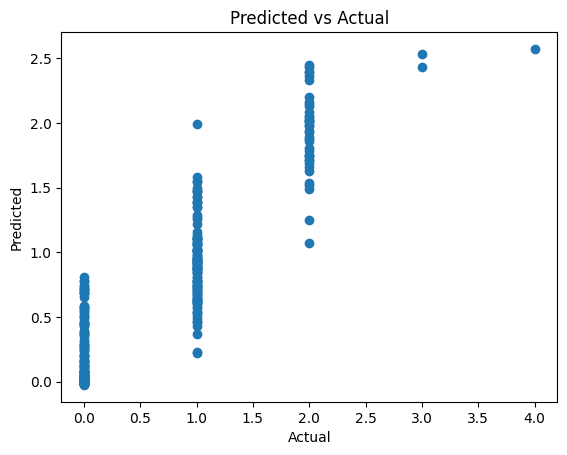

Accuracy: 69.23%


In [25]:
# We'll now use a simple MLP model
torch.set_grad_enabled(True)

NUM_FEATURES = X.shape[1]
NUM_CLASSES = 4

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(NUM_FEATURES, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, NUM_CLASSES)
        self.out = torch.nn.Linear(NUM_CLASSES, 1)


    def activation(self, x):
        return torch.nn.Tanh()(x) ** 2

    def forward(self, x):
        # We'll use a sigmoid activation function for the hidden layers
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.out(x)
        return x
    
    def save_weights(self):
        torch.save(self.state_dict(), 'mlp.dat')

    def load_weights(self):
        self.load_state_dict(torch.load('mlp.dat'))
    
model = MLP()
print(model)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Let's split the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

y_train = y_train.view(-1, 1) / max(y)
y_test = y_test.view(-1, 1) / max(y)

# Now we can train the model
EPOCHS = 100
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item()}")

model.save_weights()

random_idx = np.random.randint(0, len(X_test))
test_input = X_test[random_idx]

print(f"Predicting for input: {test_input}")
print(f"Expected output: {y_test[random_idx]}")
print(f"Predicted output: {model(test_input)}")





print("\n__________________________\n")

# Now we can test the model

model = MLP()
print(model)
model.load_weights()
model.eval()

predicted = model(X_test) * max(y)
actual = y_test * max(y)

# Let's plot the predicted vs actual values
import matplotlib.pyplot as plt

plt.scatter(actual.detach().numpy(), predicted.detach().numpy())
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

# Let's calculate how close the predicted values are to the actual values
# If the prediction, rounded to the nearest integer is within 1e-6 of the actual value, we'll consider it correct

correct = 0
for i in range(len(actual)):
    if torch.abs(actual[i] - int(predicted[i])) < 1e-6:
        correct += 1

accuracy = correct / len(actual)
print(f"Accuracy: {accuracy * 100:.2f}%")

# A New Approach

The MLP classifier is not looking good after a bit of experimentation.
Let's see if we can't now try and look at the adjacency matrices

In [30]:
# The adj matrices are all different sizes, so we can't use them as input to the model
# We'll instead see if we can use the characteristics of the adj matrix to predict the invariants

# Let's get the characteristic polynomial of each adjacency matrix

import numpy.polynomial.polynomial as poly

# Note, the coefficients of the polynomial are in increasing order of the power of x
# e.g. [1, 2, 3] represents 1 + 2x + 3x^2
def get_characteristic_polynomial(adj_matrix):
    n = adj_matrix.shape[0]
    I = np.eye(n)
    A = adj_matrix + I
    return poly.polyfromroots(np.linalg.eigvals(A))


adj_matrices = [graph['adjacency'] for graph in graphs]
characteristic_polynomials = [get_characteristic_polynomial(adj_matrix) for adj_matrix in adj_matrices]

# Let's print 5 at random
for i in range(5):
    idx = np.random.randint(0, len(characteristic_polynomials))
    print(f"Graph {idx + 1}")
    print(characteristic_polynomials[idx])
    print()


Graph 1038
[  0.  16.  -4. -28.  11.  11.  -7.   1.]

Graph 1173
[ -5.   9.  12. -28.   6.  12.  -7.   1.]

Graph 988
[ 3.60000000e+01  3.55271368e-14 -1.33000000e+02  1.00000000e+01
  1.82000000e+02 -3.00000000e+01 -1.08000000e+02  3.00000000e+01
  2.20000000e+01 -1.00000000e+01  1.00000000e+00]

Graph 586
[ -2.   4.  13. -16. -25.  18.  11.  -8.   1.]

Graph 350
[  8.  14. -19. -23.  18.   8.  -7.   1.]



In [57]:
# Let's use the coefficients of the characteristic polynomial as input to the model

# The lengths of the polynomials are all different, so we'll need to pad them to the same length

max_degree = max(len(poly) for poly in characteristic_polynomials)
for i, poly in enumerate(characteristic_polynomials):
    characteristic_polynomials[i] = np.pad(poly, (0, max_degree - len(poly)))

# There's two things we need to do now:
# 1. make sure all values are real by taking the magnitude of the complex numbers
# 2. convert the list to a singlle numpy array before converting to a tensor

characteristic_polynomials = np.abs(np.array(characteristic_polynomials))

X = torch.tensor(characteristic_polynomials, dtype=torch.float32)
y = torch.stack([graph['invariants'][0] for graph in graphs])

print(X)
print(y)

# Let's split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


# Let's make a new model

NUM_FEATURES = X.shape[1]
NUM_CLASSES = 4

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(NUM_FEATURES, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, NUM_CLASSES)
        self.out = torch.nn.Linear(NUM_CLASSES, 1)


    def activation(self, x):
        return torch.nn.Tanh()(x)

    def forward(self, x):
        # We'll use a sigmoid activation function for the hidden layers
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.out(x)
        return x
    
    def save_weights(self):
        torch.save(self.state_dict(), 'mlp.dat')

    def load_weights(self):
        self.load_state_dict(torch.load('mlp.dat'))


model = MLP()
print(model)
criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 1000
for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item()}")

model.save_weights()

random_idx = np.random.randint(0, len(X_test))
test_input = X_test[random_idx]

print(f"Predicting for input: {test_input}")
print(f"Expected output: {y_test[random_idx]}")
print(f"Predicted output: {model(test_input)}")


tensor([[6.7277e-34, 4.0000e+00, 1.3000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.0000e+00, 5.0000e+00, 2.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.0000e+00, 7.0000e+00, 9.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+00, 1.0000e+01, 1.7764e-15,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])
tensor([1., 0., 0.,  ..., 0., 0., 2.])
MLP(
  (fc1): Linear(in_features=11, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)
Epoch 0 - Loss: 0.7374446392059326
Epoch 10 - Loss: 0.5377802